# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

In [1]:
import pandas as pd
import math
import seaborn as sns
import pylab as pl

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler

random_state = 12345

<b>Цель исследования:</b>
<br/>
Заказчик исследования — сеть отелей «Как в гостях». 
Необходимо обучить модель, которая сможет прогнозировать отказ клиента от брони в отеле. На основании этого прогноза заказчик сможет запрашивать у такиех клиентов депозит. Это позволит частично компенсировать затраты на отмененную бронь. Также, требуется составить портрет такого "ненадежного" клиента.
<br/>
<br/>
<b>Ход исследования:</b>
<br/>
Данные для обучения модели предоставлены заказчиком. В них содержится информация о бронировании номеров в отелях за несколько месяцев. Исходные данные состоят из двух таблиц: одна для тренировки моделей и одна - для их тестирования.
<br/>
<br/>
<b>Этапы исследования:</b>
* Обзор данных.
* Базовая предобработка данных.
* Подготовка данных к обучению в моделях ML.
* Анализ бизнес-задачи и формулировка на ее основе ML задачи.
* Обучение нескольких моделей с целью поиска оптимальной.
* Составление характеристики клиента, склонного к отмене брони.
* Общий вывод.

### Шаг 1. Откройте файлы с данными

In [2]:
train_df = pd.read_csv('/datasets/hotel_train.csv')
test_df = pd.read_csv('/datasets/hotel_test.csv')

#### Тренировочные данные

In [3]:
pd.set_option('max_columns', None)
train_df.info();
display(train_df.head());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


В целом, данные качественные. Но требуют предобработки перед использованием в обучении моделей:
* Нет пропусков.
* Колонка **is_canceled** - целевой признак, для прогнозирования которого будет использоваться модель.
* Колонка **id** - идентификатор из БД - не нужна для обучения и должна быть удалена.
* **arrival_date_year** - это год. Годы не повторяются, поэтому этот признак не имеет смысла при обучении. Колонку следует удалить.
* **arrival_date_week_number** и пара **[arrival_date_month, arrival_date_day_of_month]** коррелируют друг с другом. **arrival_date_week_number** следует удалить как менее информативную колонку. Кроме того, эти колонки можно рассматривать как категориальные данные (в году ограниченное количество дней и они ежегодно повторяются). Поэтому, тут может потребоваться кодирование колонок.
* **meal, country, distribution_channel, reserved_room_type, customer_type** - категориальные данные, требующие кодирования.
* **total_nights** и **[stays_in_weekend_nights, stays_in_week_nights]** - коррелируют. **total_nights** следуют удалить как менее информативную колонку.

#### Тестовые данные

In [4]:
test_df.info();
display(test_df.head());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


In [5]:
#сравнение структуры DataFrame'ов:
(test_df.dtypes == train_df.dtypes).all()

True

Структура DataFrame'ов в тренировочных и тестовых данных совпадают. Соответственно, все замечания по тренировочным данным относятся и к тестовым.

### Шаг 2. Предобработка и исследовательский анализ данных

#### Удаление лишних колонок

In [6]:
excessive_columns = [
    'id',
    'arrival_date_year',
    'arrival_date_week_number',
    'total_nights',
    
    #'stays_in_weekend_nights',
    #'stays_in_week_nights',
    #'adults',
    #'children',
    #'babies',
    #'previous_cancellations',
    #'previous_bookings_not_canceled',
    #'booking_changes',
    #'days_in_waiting_list',
    #'required_car_parking_spaces',
    #'total_of_special_requests',
    
    #'country',
    #'arrival_date_day_of_month'
]
train_df = train_df.drop(excessive_columns, axis=1)
test_df = test_df.drop(excessive_columns, axis=1)

#### Выбросы в данных

In [7]:
hist_per_row = 3
height_per_row = 4

def check_emissions(df, numeric_columns, is_numeric=True):
    columns_count = len(numeric_columns)
    rows = int(columns_count / 3) + (1 if (columns_count % 3 > 0) else 0)
    if(is_numeric):
        display(df[numeric_columns].describe())
    
    axis = df[numeric_columns].hist(figsize=(20,height_per_row * rows), layout=(rows, hist_per_row));    
    pl.suptitle("Гистограммы признаков", y=0.91)
    for ax in axis.flatten():
        ax.set_xlabel("Значение признака")
        ax.set_ylabel("Брони")

,stays_in_weekend_nights,required_car_parking_spaces,adults,stays_in_week_nights,lead_time,previous_bookings_not_canceled,total_of_special_requests,babies,days_in_waiting_list,children,previous_cancellations,booking_changes
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,0.825185,0.056647,1.836576,2.224793,96.337917,0.107713,0.512763,0.007236,3.334422,0.074890,0.128915,0.194269
std,0.853477,0.232094,0.480245,1.354992,96.127545,1.326638,0.752590,0.098790,18.239606,0.334243,0.965326,0.593838
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,1.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,2.000000,2.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,151.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,3.000000,4.000000,6.000000,374.000000,58.000000,5.000000,10.000000,259.000000,3.000000,26.000000,17.000000


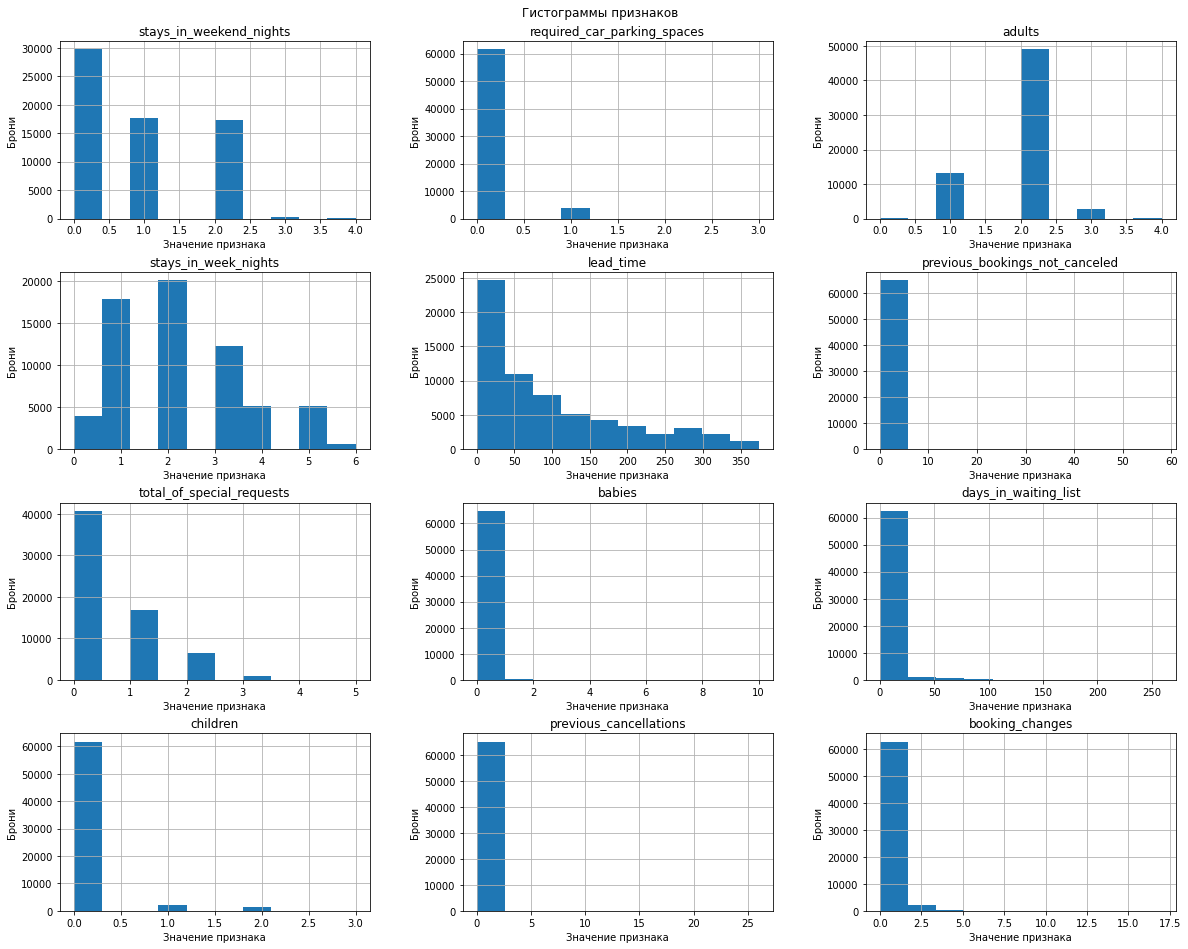

In [8]:
numerical_columns = list(set([    
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'required_car_parking_spaces',
    'total_of_special_requests'
]) - set(excessive_columns))
check_emissions(train_df, numerical_columns)

Везде нормальное распределение, для некоторых данных выглядящее как константа. Явных выбросов нет.

#### Проверка категориальных признаков

In [9]:
categorial_columns = list(set([
    'arrival_date_month',
    'arrival_date_day_of_month',
    'meal',
    'country',
    'distribution_channel',
    'reserved_room_type',
    'customer_type'
]) - set(excessive_columns))
for column_name in categorial_columns:
    print(column_name + ':')
    print(pd.concat([train_df, test_df])[column_name].unique())
    print()

country:
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'
 'ABW' 'SLV' 'DMA' 'CUB' 'PYF' 'UGA' 'GUY' 'LCA' 'ATA' 'RWA' 'MNE' 'FJI'
 'MDG' 'CAF' 'NPL' 'BHS' 'UMI' 'MYT' 'GTM' 

В **meal** и **reserved_room_type** есть пробелы в значениях. В **meal** это приводит к дублированию значения 'SC'. Следует исправить:

In [10]:
train_df['meal'] = train_df['meal'].str.strip()
train_df['reserved_room_type'] = train_df['reserved_room_type'].str.strip()

test_df['meal'] = test_df['meal'].str.strip()
test_df['reserved_room_type'] = test_df['reserved_room_type'].str.strip()

#### Выделение признаков

Обучение моделей будет проводиться с помощью GridSearchCV. Поэтому, разделение выборки на валидационную и тренировочную не требуется

In [11]:
target_train = train_df['is_canceled']
features_train_raw = train_df.drop('is_canceled', axis=1)

target_test = test_df['is_canceled']
features_test_raw = test_df.drop('is_canceled', axis=1)

#### Кодирование признаков

In [12]:
class Encoder:
    def __init__(self, underlying_encoder, encodable_columns):
        self.underlying_encoder = underlying_encoder
        self.encodable_columns = encodable_columns
        
    def fit(self, features):
        self.underlying_encoder.fit(features[self.encodable_columns])
        
    def encode(self, features):
        encoded_values = self.underlying_encoder.transform(features[self.encodable_columns])
        encoded_df = pd.DataFrame(encoded_values, columns=self.underlying_encoder.get_feature_names())
        return features.drop(self.encodable_columns, axis=1).join(encoded_df)
        
    def decode(self, features):            
        decodable_columns = features[self.underlying_encoder.get_feature_names()]
        decoded = self.underlying_encoder.inverse_transform(decodable_columns)
        return pd.DataFrame(decoded, index=features.index, columns=self.encodable_columns).join(features)

In [13]:
encoder = Encoder(OneHotEncoder(sparse=False, handle_unknown='ignore'), categorial_columns)
encoder.fit(pd.concat([features_train_raw]))
features_train = encoder.encode(features_train_raw)
features_test = encoder.encode(features_test_raw)

#### Масштабирование данных

Масштабирование поможет при обучении логистической регрессии.

In [14]:
def reverse_scaling(features):
    return pd.DataFrame(
        scaler.inverse_transform(features[numerical_columns]), 
        columns=numerical_columns, 
        index=features.index
    )

In [15]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()

existing_numerical_columns = numerical_columns
features_train[numerical_columns] = scaler.fit_transform(features_train[numerical_columns])
features_test[numerical_columns] = scaler.transform(features_test[numerical_columns])

#### Баланс классов

In [16]:
target_train.value_counts()

0    41185
1    24044
Name: is_canceled, dtype: int64

Есть дисбалланс в сторону отрицательного класса. Следует увеличить выборку. Разница маньше, чем в два раза - поэтому, для выравнивания баланса, будет взят случайный набор строк с положительным классом. 

In [17]:
def upsample(target, features):
    negative = target[target == 0]
    positive = target[target == 1]
    
    diff = negative.count() - positive.count()
    if (diff == 0):
        return (target, features)
    
    elif (diff < 0):
        additional_targets = negative.sample(-diff, random_state=random_state)
    else:
        additional_targets = positive.sample(diff, random_state=random_state)
        
    target_scaled = pd.concat([negative, positive, additional_targets])
    features_scaled = features.loc[target_scaled.index]
    
    target_scaled, features_scaled = shuffle(target_scaled, features_scaled, random_state=random_state)
    
    #на данном этапе есть дублирующиеся индексы, поэтому их следует перестроить:
    target_scaled.reset_index(inplace=True, drop=True)
    features_scaled.reset_index(inplace=True, drop=True)
    
    return (target_scaled, features_scaled)

In [18]:
#target_train, features_train = upsample(target_train, features_train)
#target_train.value_counts()

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

#### Бизнес-задача

Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

#### Прибыль без депозитов

In [19]:
prices = {
    'A': { 'overnight': 1000, 'service': 400 },
    'B': { 'overnight': 800, 'service': 350 },
    'C': { 'overnight': 600, 'service': 350 },
    'D': { 'overnight': 550, 'service': 150 },
    'E': { 'overnight': 500, 'service': 150 },
    'F': { 'overnight': 450, 'service': 150 },
    'G': { 'overnight': 350, 'service': 150 }
}

seasonal_multiplier = {
    'June': 1.4,
    'July': 1.4,
    'August': 1.4,
    
    'September': 1.2,
    'October': 1.2,
    'November': 1.2,
    
    'December': 1,
    'January': 1, 
    'February': 1,
    
    'March': 1.2,
    'April': 1.2,
    'May': 1.2
}

development_budget = 400000

deposit_multiplier = 0.8

In [20]:
def add_profit_info(row):    
    price = prices[row['reserved_room_type']]
    month = row['arrival_date_month']
    nights = row['stays_in_weekend_nights'] + row['stays_in_week_nights']#допущение: все дни съема в одном месяце
    is_cancelled = row['expected'] == 1
    is_cancellation_predicted = row['predicted'] == 1
    price_per_night = price['overnight']
    spendings = price['service']
    multiplier = seasonal_multiplier[month]
    
    base_payment = (multiplier * price['overnight'] + price['service'])
    if (is_cancelled):
        row['is_canceled'] = True
        profit = -(price_per_night * multiplier + spendings)
        if (is_cancellation_predicted):
            row['saved_profit'] = -profit * deposit_multiplier
            profit *= (1 - deposit_multiplier) #часть потерь компенсируется депозитом
        else:
            row['lost_profit'] = -profit * deposit_multiplier
    else:
        if (is_cancellation_predicted == 1):
            row['false_positive'] = True
        profit = (price_per_night * nights * multiplier) - (spendings * (1 + nights//2))
    row['profit'] = profit
    
    return row    

In [21]:
profit_info_columns = [
    'profit', 
    'saved_profit', 
    'lost_profit',    
    'false_positive',
    'is_canceled'
]
def calculate_profit(features, target, predicted):
    predicted_series = pd.Series(predicted, index=target.index, name='predicted')
    result = features.join(target.rename('expected')).join(predicted_series)
    result[profit_info_columns] = None
    return result.apply(add_profit_info, axis=1)

In [22]:
def analize_profit(features, target, predicted):
    features_rescaled = reverse_scaling(features)
    decoded = encoder.decode(features)
    decoded[numerical_columns] = features_rescaled[numerical_columns]
    
    profit_df = calculate_profit(decoded, target, predicted)
    profit_df = profit_df.append({
        'arrival_date_month': 'Итого по месяцам',
        'profit': profit_df['profit'].sum(),
        'lost_profit': profit_df['lost_profit'].sum(),
        'saved_profit': profit_df['saved_profit'].sum(),
        
        'false_positive': profit_df['false_positive'].sum(),
        'is_canceled': profit_df['is_canceled'].sum()
    }, ignore_index=True)
    
    result = profit_df.groupby('arrival_date_month').aggregate({
        'profit':['sum', 'count'],
        'lost_profit':'sum',
        'saved_profit':['sum', 'count'],
        
        'false_positive':'sum',
        'is_canceled':'sum'
    })
    
    result.columns = [
        'Прибыль',
        'Брони',
        'Возможные депозиты, сумма',
        'Депозиты, сумма',
        'Депозиты, кол-во', 
        'Ошибочные депозиты, кол-во',
        'Отмена брони'
    ]
    result.index.name = 'Месяц'
    result.at['Итого по месяцам', 'Брони'] = profit_df['profit'].count()
    result.at['Итого по месяцам', 'Депозиты, кол-во'] = profit_df['saved_profit'].count()
    
    return result

In [23]:
%%time
profit = analize_profit(features_test, target_test, target_test.replace(1, 0))
profit

CPU times: user 4.76 s, sys: 794 ms, total: 5.56 s
Wall time: 5.68 s


,Прибыль,Брони,"Возможные депозиты, сумма","Депозиты, сумма","Депозиты, кол-во","Ошибочные депозиты, кол-во",Отмена брони
Месяц,,,,,,,
April,4148130.0,4878,2430344.0,0,0,0,2173
August,5010310.0,3096,1337952.0,0,0,0,1102
February,2918600.0,3543,1124080.0,0,0,0,1135
January,2176450.0,3150,1080880.0,0,0,0,1071
July,5035260.0,3626,1621896.0,0,0,0,1331
June,4376840.0,4580,2652216.0,0,0,0,2053
March,5059570.0,4277,1564592.0,0,0,0,1411
May,3857760.0,5262,2621288.0,0,0,0,2315
Итого по месяцам,32582920.0,32413,14433248.0,0,1,0,12591


30% броней отменяется, что приводит к существенным потерям. Так, на 35 млн. дохода приходится 14 млн., которые теоретичски можно было бы компенсировать при введении депозитов.

#### ML задача

Если в качестве тестового периода рассматривать один месяц, то:
* По месяцу с минимально возможной компенсацией от депозитов (добиться окупаемости труднее всего) можно взять минимальный FP прогноз.
* Помимо бюджета следует минимизировать лишние запросы депозитов у надежных клиентов. Пусть допустимый процент таких ошибок будет 10%.

In [24]:
month_with_minimum_possible_deposit = profit['Возможные депозиты, сумма'].idxmin()
minimal_deposit = profit['Возможные депозиты, сумма'][month_with_minimum_possible_deposit]
cancelled = profit['Отмена брони'][month_with_minimum_possible_deposit]
reserves = profit['Брони'][month_with_minimum_possible_deposit]

target_fp_fraction = 0.1
min_recall = development_budget / minimal_deposit
min_tp = min_recall * cancelled
max_fp = (reserves - cancelled) * target_fp_fraction
min_precision = min_tp / (min_tp + max_fp)

print(f'Месяц: {month_with_minimum_possible_deposit}, минимальная полнота: {min_recall:.2f}, минимальная точность:{min_precision:.2f}')

Месяц: January, минимальная полнота: 0.37, минимальная точность:0.66


К точности требования оказались выше, поэтому при обучении модель будет оцениваться именно по точности.

### Шаг 4. Разработка модели ML

In [25]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score
def analize(model, features, target):
    predicted = model.predict(features)
    probabilities = model.predict_proba(features)
    roc_auc = roc_auc_score(target, probabilities[:, 1])
    print(f'Точность: {model.score(features, target):.2f}, полнота: {recall_score(target, predicted):.2f}, roc auc: {roc_auc:.2f}')
    display(analize_profit(features, target, model.predict(features)));

In [26]:
scoring = ['precision', 'recall', 'roc_auc']
def model_info(search_model):
    print('Модель с лучшими параметрами:', search_model.best_estimator_)
    results = search_model.cv_results_
    best_index = search_model.best_index_
    
    for score_name in scoring:
        best_score = results[f'mean_test_{score_name}'][best_index]
        print(f'{score_name}: {best_score:.2}')

#### Дерево решений

In [27]:
%%time

#обычно занимает 1-2 минуты
tree = GridSearchCV(
    DecisionTreeClassifier(random_state=random_state),
    {
        'max_depth': [50, 100, 150],
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random']
    },
    refit='precision',
    scoring=scoring
).fit(features_train, target_train)

CPU times: user 53.9 s, sys: 4.95 s, total: 58.8 s
Wall time: 59.1 s


In [28]:
model_info(tree)

Модель с лучшими параметрами: DecisionTreeClassifier(criterion='entropy', max_depth=50, random_state=12345)
precision: 0.49
recall: 0.46
roc_auc: 0.59


#### Лес решений

In [29]:
%%time

#обычно занимает 3-4 минуты
forest = GridSearchCV(
    RandomForestClassifier(random_state=random_state, n_jobs=-1, n_estimators=100),
    {
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2']
    },
    refit='precision',
    scoring=scoring
).fit(features_train, target_train)

CPU times: user 3min 53s, sys: 3.13 s, total: 3min 56s
Wall time: 3min 56s


In [30]:
model_info(forest)

Модель с лучшими параметрами: RandomForestClassifier(criterion='entropy', max_features='sqrt', n_jobs=-1,
                       random_state=12345)
precision: 0.59
recall: 0.45
roc_auc: 0.65


#### Логистическая регрессия

In [31]:
%%time

#обычно занимает 2-3 минуты
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore") #подавление предупреждений о нехватке итераций
    
    regression = GridSearchCV(
        LogisticRegression(random_state=random_state, solver='liblinear'),
        {
            'penalty': ['l1', 'l2'],
            'max_iter': [25, 50, None]
        },
        refit='precision',
        scoring=scoring
    ).fit(features_train, target_train)

CPU times: user 2min 23s, sys: 6.25 s, total: 2min 29s
Wall time: 2min 30s


In [32]:
model_info(regression)

Модель с лучшими параметрами: LogisticRegression(max_iter=25, penalty='l1', random_state=12345,
                   solver='liblinear')
precision: 0.59
recall: 0.49
roc_auc: 0.71


#### Тестирование лучшей модели

Из всех моделей лучше всего себя показала логистическая регрессия

In [33]:
%%time

best_model = regression
analize(best_model, features_test, target_test)

Точность: 0.79, полнота: 0.53, roc auc: 0.83


,Прибыль,Брони,"Возможные депозиты, сумма","Депозиты, сумма","Депозиты, кол-во","Ошибочные депозиты, кол-во",Отмена брони
Месяц,,,,,,,
April,5712042.0,4878,866432.0,1563912.0,1338,246,2173
August,5621206.0,3096,727056.0,610896.0,518,354,1102
February,3395920.0,3543,646760.0,477320.0,463,135,1135
January,2584170.0,3150,673160.0,407720.0,403,75,1071
July,5702220.0,3626,954936.0,666960.0,534,189,1331
June,6160176.0,4580,868880.0,1783336.0,1344,311,2053
March,5929122.0,4277,695040.0,869552.0,746,228,1411
May,5461264.0,5262,1017784.0,1603504.0,1347,245,2315
Итого по месяцам,40566120.0,32413,6450048.0,7983200.0,6694,1783,12591


CPU times: user 5.05 s, sys: 1.06 s, total: 6.1 s
Wall time: 6.09 s


И полнота и точность превосходят минимальные целевые значения, определенные в "**3.3.ML задача**"

Модель без труда может отбить бюджет уже в первый месяц использования. При этом, высокая точность позволит не беспокоить лишний раз надежных клиентов.

### Шаг 5. Опишите портрет «ненадёжного» клиента

Перебором были найдены наиболее показательные графики

In [34]:
df = pd.concat([test_df, train_df])

In [35]:
def draw(df, column):
    if (len(df[column].unique()) <= 50):
        values = 'adults'
        if(column == values):
            values = 'required_car_parking_spaces'
        pvt = df.pivot_table(
            index=[column, 'is_canceled'], 
            values=values,
            aggfunc='count').round(2).reset_index()

        ax = sns.barplot(
            x=column,
            y=values,
            hue='is_canceled',
            data=pvt,
            palette=['lightblue', 'orange']
        )

        ax.set_title(f'График признака "{column}" с разбивкой по факту отмены брони')
        ax.set(xlabel='Значения признака', ylabel='Брони');
        handles, labs = ax.get_legend_handles_labels()
        pl.legend(handles=handles, labels=['Бронь оплачена', 'Бронь отменена'])
    else:
        axis = df.groupby('is_canceled')[column].hist(bins=35, alpha=0.5);
        pl.suptitle(f'Гистограмма признака "{column}" с разбивкой по факту отмены брони')
        pl.legend(['Бронь оплачена', 'Бронь отменена']);
        for ax in axis:
            ax.set_xlabel("Значения признака")
            ax.set_ylabel("Брони")

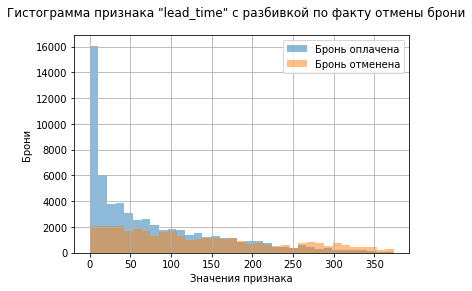

In [36]:
draw(df, 'lead_time')

Самое заметное отличие "ненадежного" клиента - это бронирование заранее. Большинство клиентов предпочитают бронировать ближе к дате заезда.

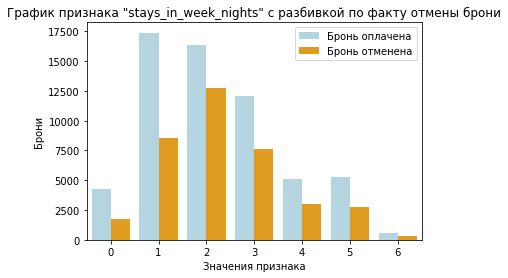

In [37]:
draw(df, 'stays_in_week_nights')

Такие клиенты относительно чаще остальных снимают номер на две ночи.

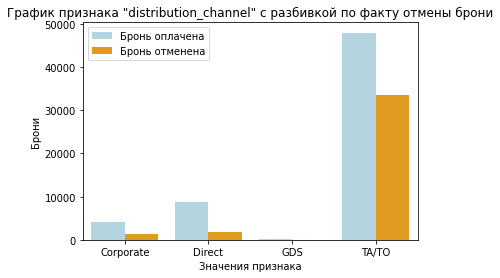

In [38]:
draw(df, 'distribution_channel')

В качестве канала распространения предпочитают TA/TO.

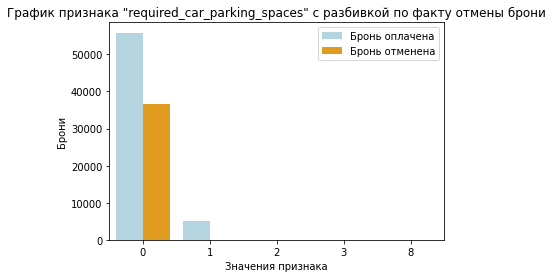

In [39]:
draw(df, 'required_car_parking_spaces')

Обходятся без личного автомобиля.

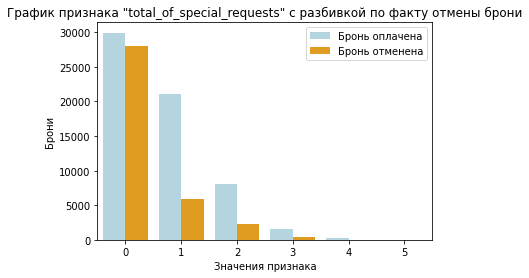

In [40]:
draw(df, 'total_of_special_requests')

Не делают дополнительных особых заказов.

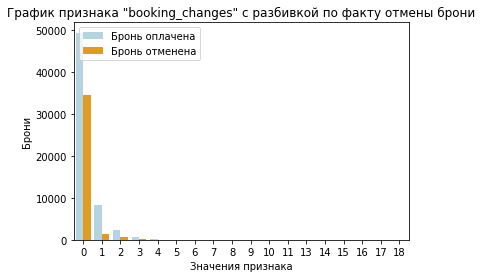

In [41]:
draw(df, 'booking_changes')

И редко редактируют бронь.

Итого:

* В основном, "ненадежные" клиенты от "надежных" не имеют серьезных отличий.
* Из заметного:
** Чаще бронированируют заранее.
** Реже редактируют бронь.
** Реже делают особые заказы.
** Обходятся без личного автомобиля.
** В качестве канала распространения чаще используют TA/TO.
** Чаще берут номер на две ночи.

### Шаг 6. Напишите общий вывод

* Исходные данные были высокого качества и потребовали лишь стандартную обработку для использования в обучении моделей.
* Перебором гиперпараметров и кросс-валидацией была найдена модель, которая должна удовлетворить пожеланию заказчика:
** использование модели покроет бюджет системы уже в первый месяц использования;
** модель обладает высокой точностью: по тестовым данным меньше 10% надежных клиентов получило бы запрос на депозит.
* В целом, введение депозитов с получившейся моделью позволит компенсировать порядка 50% потерь от отмены броней.